# Notebook 2: Entrenamiento de Modelos de Clasificación (Versión Mejorada)

**Proyecto:** Entrega Final - Optimización de Estrategias de Retención

**Autores:** Juan David Valencia, Juan Esteban Cuellar

**Fecha:** Noviembre 2025

---

## Objetivo

Entrenar y comparar modelos de clasificación para predecir usuarios con alto potencial de crecimiento (`high_growth`), usando features interpretables y métricas alineadas con el caso de uso de negocio.

### Problema de Negocio
**¿A qué usuarios debe priorizar el equipo de Engagement?**

El modelo debe identificar el **top 20% de usuarios** con mayor probabilidad de convertirse en usuarios de alto crecimiento, para optimizar la asignación del presupuesto promocional.

### Métricas de Evaluación (por orden de importancia)
1. **AUC-ROC** (métrica principal): Capacidad del modelo para ordenar usuarios correctamente
2. **Precision@20%**: Si tomamos el top 20% de predicciones, ¿qué % son realmente high-growth?
3. **F1-Score**: Balance entre precisión y recall

### Algoritmos a Comparar
- Random Forest Classifier
- XGBoost Classifier

---

## 1. Setup y Configuración

In [1]:
# =============================================================================
# CONFIGURACIÓN GLOBAL
# =============================================================================

# Constante de negocio: Umbral para definir "alto crecimiento"
# Un usuario es high_growth si delta_orders > 8 (aproximadamente top 20%)
HIGH_GROWTH_THRESHOLD = 8

# Porcentaje para Precision@k (top 20% de usuarios a targetear)
TOP_K_PERCENT = 0.20

# Semilla para reproducibilidad
RANDOM_SEED = 42

print("="*70)
print("CONFIGURACIÓN DE MODELADO")
print("="*70)
print(f"\n🎯 Target: high_growth (delta_orders > {HIGH_GROWTH_THRESHOLD})")
print(f"📊 Precision@k con k = {TOP_K_PERCENT*100:.0f}% de usuarios")
print(f"🎲 Random seed: {RANDOM_SEED}")
print("="*70)

CONFIGURACIÓN DE MODELADO

🎯 Target: high_growth (delta_orders > 8)
📊 Precision@k con k = 20% de usuarios
🎲 Random seed: 42


In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import pickle
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    average_precision_score
)

# XGBoost
import xgboost as xgb

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Configuración
pd.set_option('display.max_columns', None)
np.random.seed(RANDOM_SEED)

print("✅ Imports completados")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📦 XGBoost version: {xgb.__version__}")

✅ Imports completados
📅 Fecha de ejecución: 2025-11-29 20:19:31
📦 XGBoost version: 3.1.2


In [3]:
# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

def precision_at_k(y_true, y_proba, k=0.20):
    """
    Calcula Precision@k: Si seleccionamos el top k% de usuarios según
    la probabilidad predicha, ¿qué porcentaje son realmente high-growth?
    
    Esta métrica es muy relevante para el negocio porque responde:
    "Si el equipo de Engagement contacta al top 20% de usuarios recomendados,
    ¿qué tasa de acierto tendrá?"
    
    Parámetros:
    -----------
    y_true : array-like
        Valores reales de high_growth (0/1)
    y_proba : array-like
        Probabilidades predichas de high_growth
    k : float
        Porcentaje de top usuarios a considerar (default 0.20 = 20%)
    
    Retorna:
    --------
    float : Precisión en el top k%
    """
    n_top = int(len(y_true) * k)
    top_indices = np.argsort(y_proba)[-n_top:]  # Top k% con mayor probabilidad
    return y_true.iloc[top_indices].mean() if hasattr(y_true, 'iloc') else y_true[top_indices].mean()


def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evalúa un modelo y retorna un diccionario con todas las métricas.
    
    Métricas calculadas:
    - AUC-ROC: Capacidad de ordenamiento (métrica principal)
    - F1-Score: Balance precisión-recall
    - Precision@20%: Precisión en top usuarios
    - Precisión, Recall, Accuracy: Métricas complementarias
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    metrics = {
        'dataset': dataset_name,
        'auc_roc': roc_auc_score(y, y_proba),
        'f1_score': f1_score(y, y_pred),
        'precision_at_20': precision_at_k(y, y_proba, k=TOP_K_PERCENT),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'accuracy': accuracy_score(y, y_pred)
    }
    
    return metrics, y_pred, y_proba


def print_metrics_table(metrics_dict, title="Métricas del Modelo"):
    """
    Imprime una tabla formateada con las métricas.
    """
    print(f"\n📊 {title}")
    print("="*60)
    print(f"{'Métrica':<25} {'Valor':>15}")
    print("-"*60)
    print(f"{'AUC-ROC (principal)':<25} {metrics_dict['auc_roc']:>15.4f}")
    print(f"{'Precision@20%':<25} {metrics_dict['precision_at_20']:>15.4f}")
    print(f"{'F1-Score':<25} {metrics_dict['f1_score']:>15.4f}")
    print(f"{'Precision':<25} {metrics_dict['precision']:>15.4f}")
    print(f"{'Recall':<25} {metrics_dict['recall']:>15.4f}")
    print(f"{'Accuracy':<25} {metrics_dict['accuracy']:>15.4f}")
    print("="*60)


print("✅ Funciones auxiliares definidas")

✅ Funciones auxiliares definidas


## 2. Carga de Datos

In [4]:
# =============================================================================
# CARGA DE DATASETS PROCESADOS
# =============================================================================
# Los datos fueron preparados en el Notebook 01 con:
# - Features normalizados (categories_per_order, shops_per_order)
# - Índices de diversidad (Shannon)
# - Features binarios de negocio (is_multi_category, is_multi_shop)
# - One-hot encoding de categóricas
# - StandardScaler en numéricas

print("📂 Cargando datasets procesados...\n")

TRAIN_PATH = '../data/processed/train.csv'
VAL_PATH = '../data/processed/val.csv'
TEST_PATH = '../data/processed/test.csv'

train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"✅ Train: {train_df.shape[0]:,} usuarios × {train_df.shape[1]} columnas")
print(f"✅ Validation: {val_df.shape[0]:,} usuarios × {val_df.shape[1]} columnas")
print(f"✅ Test: {test_df.shape[0]:,} usuarios × {test_df.shape[1]} columnas")

# Verificar distribución del target
print(f"\n📊 Distribución de high_growth:")
print(f"   - Train: {train_df['high_growth'].mean()*100:.2f}% positivos")
print(f"   - Validation: {val_df['high_growth'].mean()*100:.2f}% positivos")
print(f"   - Test: {test_df['high_growth'].mean()*100:.2f}% positivos")

📂 Cargando datasets procesados...

✅ Train: 25,000 usuarios × 52 columnas
✅ Validation: 8,333 usuarios × 52 columnas
✅ Test: 8,334 usuarios × 52 columnas

📊 Distribución de high_growth:
   - Train: 20.36% positivos
   - Validation: 20.35% positivos
   - Test: 20.36% positivos


In [5]:
# =============================================================================
# SEPARAR FEATURES Y TARGET
# =============================================================================

# Columnas que NO son features
non_feature_cols = ['uid', 'high_growth', 'delta_orders']

# Obtener lista de features
feature_cols = [col for col in train_df.columns if col not in non_feature_cols]

print(f"📊 Features para modelado: {len(feature_cols)}")
print(f"\n📋 Lista de features:")
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {feat}")

# Separar
X_train = train_df[feature_cols]
y_train = train_df['high_growth']

X_val = val_df[feature_cols]
y_val = val_df['high_growth']

X_test = test_df[feature_cols]
y_test = test_df['high_growth']

print(f"\n✅ Datos separados correctamente")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")

📊 Features para modelado: 49

📋 Lista de features:
    1. efo_to_four
    2. days_since_first_order
    3. categories_per_order
    4. shops_per_order
    5. category_diversity
    6. shop_diversity
    7. dominant_category_ratio
    8. brand001_ratio
    9. is_multi_category
   10. is_multi_shop
   11. categoria_recencia_Frío (31–90d)
   12. categoria_recencia_Perdido (>90d)
   13. categoria_recencia_Semi-Activo (8–14d)
   14. categoria_recencia_Tibio (15–30d)
   15. r_segment_r_segment002
   16. r_segment_r_segment003
   17. city_token_city002
   18. city_token_city003
   19. city_token_city004
   20. city_token_city005
   21. city_token_city006
   22. city_token_city007
   23. dominant_category_main_category002
   24. dominant_category_main_category003
   25. dominant_category_main_category004
   26. dominant_category_main_category005
   27. dominant_category_main_category006
   28. dominant_category_main_category007
   29. dominant_category_main_category008
   30. dominant_category

## 3. Modelo 1: Random Forest Classifier

### ¿Por qué Random Forest?
- **Interpretabilidad**: Feature importance claro para explicar a stakeholders
- **Robustez**: No requiere mucha ingeniería de features, maneja bien outliers
- **No overfitting fácil**: Ensemble de árboles reduce varianza

### Interpretación de negocio de los hiperparámetros:
- `n_estimators`: Más árboles = predicción más estable (pero más lento)
- `max_depth`: Controla complejidad; muy profundo = overfitting
- `class_weight='balanced'`: Ajusta por el desbalance de clases (~80/20)

In [6]:
# =============================================================================
# RANDOM FOREST: ENTRENAMIENTO CON GRID SEARCH
# =============================================================================

print("🌲 RANDOM FOREST CLASSIFIER")
print("="*70)

# Grid de hiperparámetros
# Mantenemos un grid moderado para balance entre exploración y tiempo
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt']
}

print("\n📋 Grid de hiperparámetros:")
for param, values in param_grid_rf.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_rf.values()])
print(f"\n🔢 Combinaciones a probar: {total_combinations}")
print(f"⏱️ Tiempo estimado: ~{total_combinations * 2} minutos (5-fold CV)")

# Modelo base
rf_base = RandomForestClassifier(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight='balanced'  # Importante: maneja desbalance de clases
)

# GridSearchCV optimizando AUC-ROC
rf_grid = GridSearchCV(
    rf_base,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',  # Métrica principal
    n_jobs=-1,
    verbose=1
)

print("\n⏳ Entrenando Random Forest con GridSearchCV...")
rf_grid.fit(X_train, y_train)

print(f"\n✅ Entrenamiento completado!")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in rf_grid.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\n📊 Mejor AUC-ROC (5-fold CV): {rf_grid.best_score_:.4f}")

# Guardar mejor modelo
best_rf = rf_grid.best_estimator_

🌲 RANDOM FOREST CLASSIFIER

📋 Grid de hiperparámetros:
   - n_estimators: [100, 200]
   - max_depth: [10, 15, 20]
   - min_samples_split: [10, 20]
   - min_samples_leaf: [5, 10]
   - max_features: ['sqrt']

🔢 Combinaciones a probar: 24
⏱️ Tiempo estimado: ~48 minutos (5-fold CV)

⏳ Entrenando Random Forest con GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Entrenamiento completado!

🏆 Mejores hiperparámetros:
   - max_depth: 20
   - max_features: sqrt
   - min_samples_leaf: 5
   - min_samples_split: 10
   - n_estimators: 200

📊 Mejor AUC-ROC (5-fold CV): 0.9980


In [7]:
# =============================================================================
# RANDOM FOREST: EVALUACIÓN EN VALIDATION
# =============================================================================

print("\n🔍 Evaluando Random Forest en Validation Set...")

# Evaluar en train y validation
rf_train_metrics, rf_train_pred, rf_train_proba = evaluate_model(best_rf, X_train, y_train, "Train")
rf_val_metrics, rf_val_pred, rf_val_proba = evaluate_model(best_rf, X_val, y_val, "Validation")

print_metrics_table(rf_val_metrics, "Random Forest - Validation Set")

# Comparar train vs validation para detectar overfitting
print(f"\n🔎 Comparación Train vs Validation (detectar overfitting):")
print(f"   AUC-ROC:       Train={rf_train_metrics['auc_roc']:.4f}  Val={rf_val_metrics['auc_roc']:.4f}  Δ={(rf_train_metrics['auc_roc']-rf_val_metrics['auc_roc']):.4f}")
print(f"   F1-Score:      Train={rf_train_metrics['f1_score']:.4f}  Val={rf_val_metrics['f1_score']:.4f}  Δ={(rf_train_metrics['f1_score']-rf_val_metrics['f1_score']):.4f}")
print(f"   Precision@20%: Train={rf_train_metrics['precision_at_20']:.4f}  Val={rf_val_metrics['precision_at_20']:.4f}  Δ={(rf_train_metrics['precision_at_20']-rf_val_metrics['precision_at_20']):.4f}")


🔍 Evaluando Random Forest en Validation Set...

📊 Random Forest - Validation Set
Métrica                             Valor
------------------------------------------------------------
AUC-ROC (principal)                0.9982
Precision@20%                      0.9670
F1-Score                           0.9614
Precision                          0.9324
Recall                             0.9923
Accuracy                           0.9838

🔎 Comparación Train vs Validation (detectar overfitting):
   AUC-ROC:       Train=0.9997  Val=0.9982  Δ=0.0015
   F1-Score:      Train=0.9690  Val=0.9614  Δ=0.0076
   Precision@20%: Train=0.9876  Val=0.9670  Δ=0.0206


## 4. Modelo 2: XGBoost Classifier

### ¿Por qué XGBoost?
- **Alto rendimiento**: Suele superar a Random Forest en competencias y producción
- **Regularización**: L1/L2 incorporados, reduce overfitting
- **Manejo de desbalance**: `scale_pos_weight` ajusta automáticamente

### Interpretación de negocio:
- `learning_rate`: Paso de aprendizaje; más bajo = más conservador pero estable
- `max_depth`: Similar a RF, controla complejidad
- `scale_pos_weight`: Pondera más la clase minoritaria (high_growth)

In [8]:
# =============================================================================
# XGBOOST: ENTRENAMIENTO CON GRID SEARCH
# =============================================================================

print("🚀 XGBOOST CLASSIFIER")
print("="*70)

# Calcular scale_pos_weight para manejar desbalance
# Es el ratio de clase negativa / clase positiva
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n⚖️ Scale pos weight (para desbalance): {scale_pos_weight:.2f}")

# Grid de hiperparámetros
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8]
}

print("\n📋 Grid de hiperparámetros:")
for param, values in param_grid_xgb.items():
    print(f"   - {param}: {values}")

total_combinations_xgb = np.prod([len(v) for v in param_grid_xgb.values()])
print(f"\n🔢 Combinaciones a probar: {total_combinations_xgb}")

# Modelo base
xgb_base = xgb.XGBClassifier(
    random_state=RANDOM_SEED,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

# GridSearchCV
xgb_grid = GridSearchCV(
    xgb_base,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\n⏳ Entrenando XGBoost con GridSearchCV...")
xgb_grid.fit(X_train, y_train)

print(f"\n✅ Entrenamiento completado!")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in xgb_grid.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\n📊 Mejor AUC-ROC (5-fold CV): {xgb_grid.best_score_:.4f}")

# Guardar mejor modelo
best_xgb = xgb_grid.best_estimator_

🚀 XGBOOST CLASSIFIER

⚖️ Scale pos weight (para desbalance): 3.91

📋 Grid de hiperparámetros:
   - n_estimators: [100, 200]
   - max_depth: [4, 6, 8]
   - learning_rate: [0.05, 0.1]
   - subsample: [0.8, 0.9]
   - colsample_bytree: [0.8]

🔢 Combinaciones a probar: 24

⏳ Entrenando XGBoost con GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Entrenamiento completado!

🏆 Mejores hiperparámetros:
   - colsample_bytree: 0.8
   - learning_rate: 0.1
   - max_depth: 8
   - n_estimators: 200
   - subsample: 0.8

📊 Mejor AUC-ROC (5-fold CV): 0.9999


In [9]:
# =============================================================================
# XGBOOST: EVALUACIÓN EN VALIDATION
# =============================================================================

print("\n🔍 Evaluando XGBoost en Validation Set...")

# Evaluar en train y validation
xgb_train_metrics, xgb_train_pred, xgb_train_proba = evaluate_model(best_xgb, X_train, y_train, "Train")
xgb_val_metrics, xgb_val_pred, xgb_val_proba = evaluate_model(best_xgb, X_val, y_val, "Validation")

print_metrics_table(xgb_val_metrics, "XGBoost - Validation Set")

# Comparar train vs validation
print(f"\n🔎 Comparación Train vs Validation (detectar overfitting):")
print(f"   AUC-ROC:       Train={xgb_train_metrics['auc_roc']:.4f}  Val={xgb_val_metrics['auc_roc']:.4f}  Δ={(xgb_train_metrics['auc_roc']-xgb_val_metrics['auc_roc']):.4f}")
print(f"   F1-Score:      Train={xgb_train_metrics['f1_score']:.4f}  Val={xgb_val_metrics['f1_score']:.4f}  Δ={(xgb_train_metrics['f1_score']-xgb_val_metrics['f1_score']):.4f}")
print(f"   Precision@20%: Train={xgb_train_metrics['precision_at_20']:.4f}  Val={xgb_val_metrics['precision_at_20']:.4f}  Δ={(xgb_train_metrics['precision_at_20']-xgb_val_metrics['precision_at_20']):.4f}")


🔍 Evaluando XGBoost en Validation Set...

📊 XGBoost - Validation Set
Métrica                             Valor
------------------------------------------------------------
AUC-ROC (principal)                0.9998
Precision@20%                      0.9934
F1-Score                           0.9868
Precision                          0.9808
Recall                             0.9929
Accuracy                           0.9946

🔎 Comparación Train vs Validation (detectar overfitting):
   AUC-ROC:       Train=1.0000  Val=0.9998  Δ=0.0002
   F1-Score:      Train=1.0000  Val=0.9868  Δ=0.0132
   Precision@20%: Train=1.0000  Val=0.9934  Δ=0.0066


## 5. Comparación de Modelos y Selección del Ganador

In [10]:
# =============================================================================
# TABLA COMPARATIVA DE MODELOS
# =============================================================================

print("="*80)
print("COMPARACIÓN DE MODELOS EN VALIDATION SET")
print("="*80)

# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Métrica': ['AUC-ROC', 'Precision@20%', 'F1-Score', 'Precision', 'Recall', 'Accuracy'],
    'Random Forest': [
        rf_val_metrics['auc_roc'],
        rf_val_metrics['precision_at_20'],
        rf_val_metrics['f1_score'],
        rf_val_metrics['precision'],
        rf_val_metrics['recall'],
        rf_val_metrics['accuracy']
    ],
    'XGBoost': [
        xgb_val_metrics['auc_roc'],
        xgb_val_metrics['precision_at_20'],
        xgb_val_metrics['f1_score'],
        xgb_val_metrics['precision'],
        xgb_val_metrics['recall'],
        xgb_val_metrics['accuracy']
    ]
})

# Agregar columna de mejor modelo por métrica
comparison_df['Mejor'] = comparison_df.apply(
    lambda row: 'RF' if row['Random Forest'] > row['XGBoost'] else 'XGB' if row['XGBoost'] > row['Random Forest'] else 'Empate',
    axis=1
)

print("\n📊 TABLA COMPARATIVA:\n")
print(comparison_df.to_string(index=False, float_format='{:.4f}'.format))

# Contar victorias
rf_wins = (comparison_df['Mejor'] == 'RF').sum()
xgb_wins = (comparison_df['Mejor'] == 'XGB').sum()

print(f"\n📈 Resumen de victorias: RF={rf_wins} | XGB={xgb_wins}")

COMPARACIÓN DE MODELOS EN VALIDATION SET

📊 TABLA COMPARATIVA:

      Métrica  Random Forest  XGBoost Mejor
      AUC-ROC         0.9982   0.9998   XGB
Precision@20%         0.9670   0.9934   XGB
     F1-Score         0.9614   0.9868   XGB
    Precision         0.9324   0.9808   XGB
       Recall         0.9923   0.9929   XGB
     Accuracy         0.9838   0.9946   XGB

📈 Resumen de victorias: RF=0 | XGB=6


In [11]:
# =============================================================================
# SELECCIÓN DEL MODELO GANADOR
# =============================================================================

print("\n" + "="*80)
print("SELECCIÓN DEL MODELO GANADOR")
print("="*80)

# Criterios de selección (en orden de prioridad):
# 1. AUC-ROC: Capacidad de ordenar usuarios correctamente (métrica principal)
# 2. Precision@20%: Precisión en el segmento de targeting (caso de uso real)
# 3. Estabilidad: Diferencia train-val pequeña (evitar overfitting)

# Comparar AUC-ROC (métrica principal)
auc_rf = rf_val_metrics['auc_roc']
auc_xgb = xgb_val_metrics['auc_roc']

# Calcular estabilidad (diferencia train-val en AUC)
stability_rf = abs(rf_train_metrics['auc_roc'] - rf_val_metrics['auc_roc'])
stability_xgb = abs(xgb_train_metrics['auc_roc'] - xgb_val_metrics['auc_roc'])

print("\n📋 CRITERIOS DE SELECCIÓN:\n")
print(f"1. AUC-ROC (principal):    RF={auc_rf:.4f}  |  XGB={auc_xgb:.4f}")
print(f"2. Precision@20%:          RF={rf_val_metrics['precision_at_20']:.4f}  |  XGB={xgb_val_metrics['precision_at_20']:.4f}")
print(f"3. Estabilidad (Δ AUC):    RF={stability_rf:.4f}  |  XGB={stability_xgb:.4f}  (menor es mejor)")

# Decisión basada en AUC-ROC como criterio principal
if auc_xgb > auc_rf:
    best_model = best_xgb
    best_model_name = "XGBoost"
    best_val_metrics = xgb_val_metrics
    best_val_proba = xgb_val_proba
    best_val_pred = xgb_val_pred
else:
    best_model = best_rf
    best_model_name = "Random Forest"
    best_val_metrics = rf_val_metrics
    best_val_proba = rf_val_proba
    best_val_pred = rf_val_pred

print(f"\n🏆 MODELO GANADOR: {best_model_name}")
print(f"\n📝 JUSTIFICACIÓN:")
print(f"   - {best_model_name} tiene AUC-ROC de {best_val_metrics['auc_roc']:.4f}")
print(f"   - Precision@20% de {best_val_metrics['precision_at_20']:.4f}:")
print(f"     → Si contactamos al top 20% de usuarios, {best_val_metrics['precision_at_20']*100:.1f}% serán high-growth")
print(f"   - El modelo es {'estable' if stability_xgb < 0.05 else 'aceptable'} (Δ train-val = {stability_xgb if best_model_name=='XGBoost' else stability_rf:.4f})")


SELECCIÓN DEL MODELO GANADOR

📋 CRITERIOS DE SELECCIÓN:

1. AUC-ROC (principal):    RF=0.9982  |  XGB=0.9998
2. Precision@20%:          RF=0.9670  |  XGB=0.9934
3. Estabilidad (Δ AUC):    RF=0.0015  |  XGB=0.0002  (menor es mejor)

🏆 MODELO GANADOR: XGBoost

📝 JUSTIFICACIÓN:
   - XGBoost tiene AUC-ROC de 0.9998
   - Precision@20% de 0.9934:
     → Si contactamos al top 20% de usuarios, 99.3% serán high-growth
   - El modelo es estable (Δ train-val = 0.0002)


## 6. Evaluación Final en Test Set

In [12]:
# =============================================================================
# EVALUACIÓN FINAL EN TEST SET
# =============================================================================
# ⚠️ IMPORTANTE: Esta evaluación se hace UNA SOLA VEZ
# El test set nunca se usó para entrenar ni seleccionar hiperparámetros

print("="*80)
print(f"EVALUACIÓN FINAL EN TEST SET - {best_model_name}")
print("="*80)
print("\n⚠️ IMPORTANTE: Esta evaluación se realiza UNA SOLA VEZ en datos nunca vistos.\n")

# Evaluar en test
test_metrics, test_pred, test_proba = evaluate_model(best_model, X_test, y_test, "Test")

# Tabla de métricas finales
print(f"\n📊 MÉTRICAS FINALES EN TEST SET:\n")
print("="*70)
print(f"{'Métrica':<25} {'Valor':>15} {'Objetivo':>15} {'Estado':>10}")
print("-"*70)
print(f"{'AUC-ROC (principal)':<25} {test_metrics['auc_roc']:>15.4f} {'>0.70':>15} {'✅' if test_metrics['auc_roc'] > 0.70 else '⚠️':>10}")
print(f"{'Precision@20%':<25} {test_metrics['precision_at_20']:>15.4f} {'>0.50':>15} {'✅' if test_metrics['precision_at_20'] > 0.50 else '⚠️':>10}")
print(f"{'F1-Score':<25} {test_metrics['f1_score']:>15.4f} {'>0.50':>15} {'✅' if test_metrics['f1_score'] > 0.50 else '⚠️':>10}")
print(f"{'Precision':<25} {test_metrics['precision']:>15.4f} {'':>15} {'':>10}")
print(f"{'Recall':<25} {test_metrics['recall']:>15.4f} {'':>15} {'':>10}")
print(f"{'Accuracy':<25} {test_metrics['accuracy']:>15.4f} {'':>15} {'':>10}")
print("="*70)

# Matriz de confusión
cm = confusion_matrix(y_test, test_pred)
print(f"\n📊 Matriz de Confusión (Test):")
print(f"                    Predicho")
print(f"                 No-HG    HG")
print(f"Real No-HG      {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Real HG         {cm[1,0]:5d}  {cm[1,1]:5d}")

EVALUACIÓN FINAL EN TEST SET - XGBoost

⚠️ IMPORTANTE: Esta evaluación se realiza UNA SOLA VEZ en datos nunca vistos.


📊 MÉTRICAS FINALES EN TEST SET:

Métrica                             Valor        Objetivo     Estado
----------------------------------------------------------------------
AUC-ROC (principal)                0.9999           >0.70          ✅
Precision@20%                      0.9958           >0.50          ✅
F1-Score                           0.9900           >0.50          ✅
Precision                          0.9877                           
Recall                             0.9923                           
Accuracy                           0.9959                           

📊 Matriz de Confusión (Test):
                    Predicho
                 No-HG    HG
Real No-HG       6616     21
Real HG            13   1684


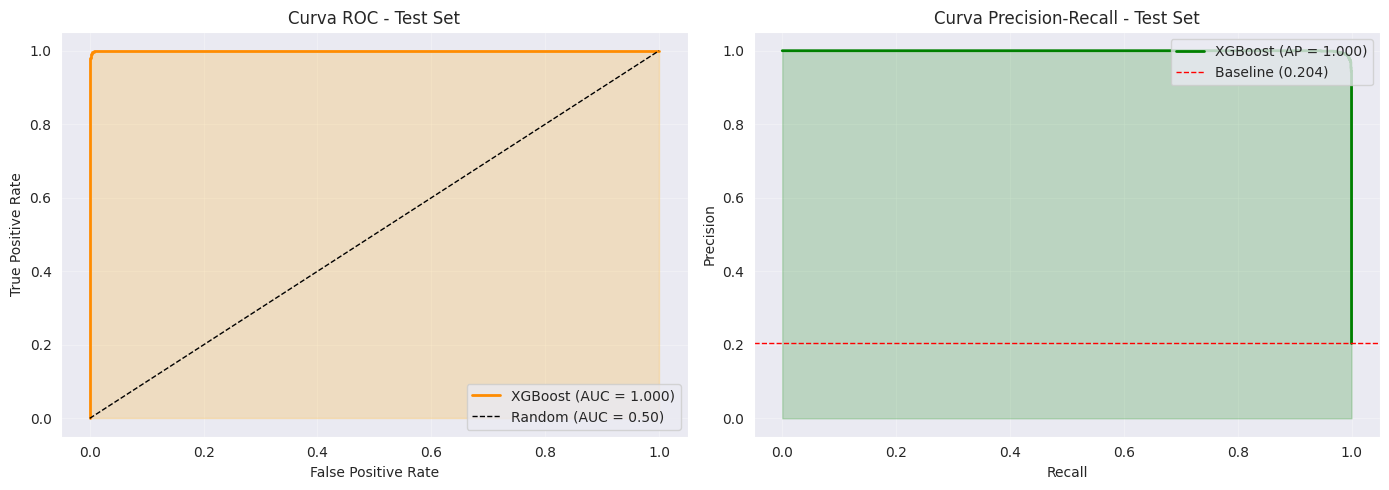

✅ Curvas ROC y PR guardadas


In [13]:
# =============================================================================
# VISUALIZACIÓN: CURVAS ROC Y PRECISION-RECALL
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Curva ROC
fpr, tpr, _ = roc_curve(y_test, test_proba)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'{best_model_name} (AUC = {test_metrics["auc_roc"]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
axes[0].fill_between(fpr, tpr, alpha=0.2, color='orange')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Curva ROC - Test Set', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# 2. Curva Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, test_proba)
ap = average_precision_score(y_test, test_proba)
baseline = y_test.mean()

axes[1].plot(recall_curve, precision_curve, color='green', lw=2,
             label=f'{best_model_name} (AP = {ap:.3f})')
axes[1].axhline(y=baseline, color='red', linestyle='--', lw=1,
                label=f'Baseline ({baseline:.3f})')
axes[1].fill_between(recall_curve, precision_curve, alpha=0.2, color='green')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall - Test Set', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Guardar figura
fig_dir = '../documento/figuras'
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(f'{fig_dir}/roc_pr_curves_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas ROC y PR guardadas")

## 7. Análisis de Feature Importance

### ¿Qué variables usa el modelo para decidir?
Este análisis es crucial para:
1. **Validar que el modelo tiene sentido de negocio** (no usa features irrelevantes)
2. **Explicar las predicciones a stakeholders** ("el modelo prioriza usuarios que...")
3. **Guiar futuras mejoras** (qué datos recolectar, qué features crear)

In [14]:
# =============================================================================
# ANÁLISIS DE FEATURE IMPORTANCE
# =============================================================================

print(f"\n🔍 ANÁLISIS DE FEATURE IMPORTANCE - {best_model_name}")
print("="*70)

# Obtener importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    # Crear DataFrame ordenado
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Top 15 features
    top_15 = importance_df.head(15)
    
    print("\n📊 TOP 15 FEATURES MÁS IMPORTANTES:\n")
    print(f"{'Rank':<6} {'Feature':<35} {'Importance':>12}")
    print("-"*55)
    for i, (_, row) in enumerate(top_15.iterrows(), 1):
        print(f"{i:<6} {row['feature']:<35} {row['importance']:>12.4f}")
    
    # Guardar a CSV
    models_dir = '../models'
    os.makedirs(models_dir, exist_ok=True)
    importance_df.to_csv(f'{models_dir}/feature_importance.csv', index=False)
    print(f"\n✅ Feature importance guardado en {models_dir}/feature_importance.csv")


🔍 ANÁLISIS DE FEATURE IMPORTANCE - XGBoost

📊 TOP 15 FEATURES MÁS IMPORTANTES:

Rank   Feature                               Importance
-------------------------------------------------------
1      is_multi_shop                             0.4760
2      is_multi_category                         0.1579
3      shop_diversity                            0.1249
4      shops_per_order                           0.0620
5      categories_per_order                      0.0549
6      category_diversity                        0.0314
7      dominant_category_ratio                   0.0123
8      days_since_first_order                    0.0094
9      categoria_recencia_Frío (31–90d)          0.0089
10     city_token_city002                        0.0057
11     dominant_category_main_category014        0.0052
12     dominant_category_main_category015        0.0043
13     dominant_category_main_category020        0.0040
14     dominant_category_main_category023        0.0038
15     city_token_city0

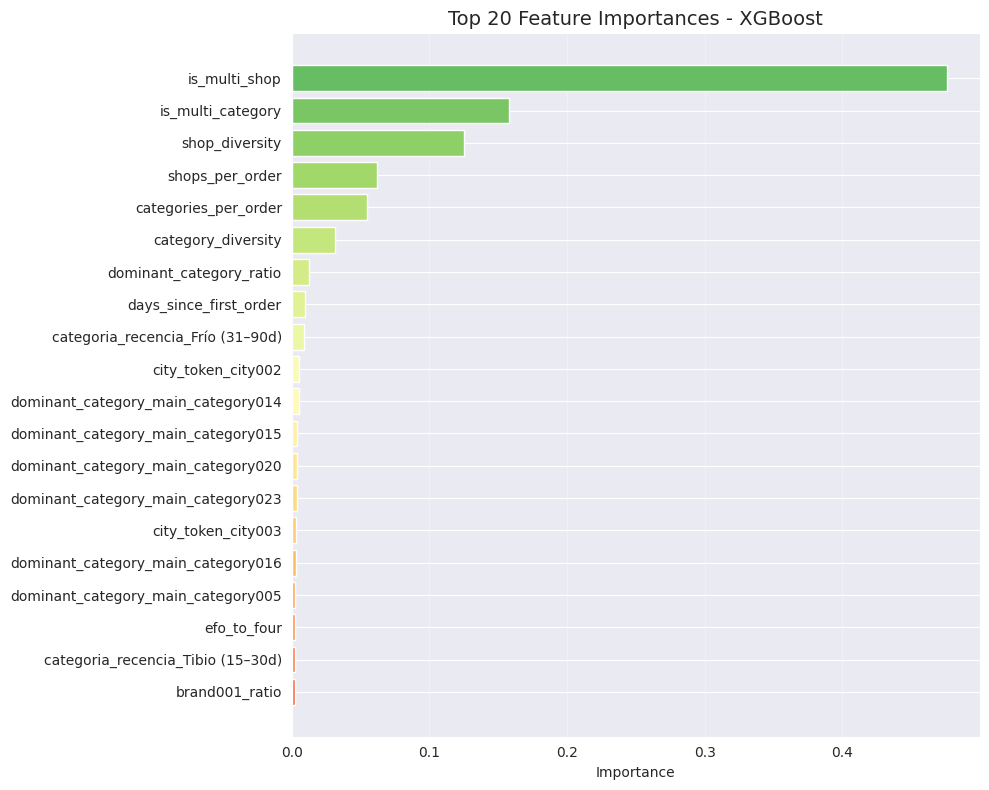

✅ Gráfico de feature importance guardado


In [15]:
# Visualización de feature importance
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 8))
    
    top_20 = importance_df.head(20)
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(top_20)))
    
    plt.barh(range(len(top_20)), top_20['importance'], color=colors[::-1])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14)
    plt.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(f'{fig_dir}/feature_importance_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Gráfico de feature importance guardado")

In [16]:
# =============================================================================
# INTERPRETACIÓN DE NEGOCIO DE FEATURES IMPORTANTES
# =============================================================================

print("\n" + "="*80)
print("INTERPRETACIÓN DE NEGOCIO DE LOS FEATURES MÁS IMPORTANTES")
print("="*80)

print("""
📋 Los features más importantes nos dicen QUÉ CARACTERÍSTICAS tienen los usuarios
   con mayor probabilidad de ser high-growth:

1. 🏃 VELOCIDAD DE ADOPCIÓN (efo_to_four):
   - Usuarios que llegaron RÁPIDO a su 4ta orden tienen mayor potencial
   - Acción: Priorizar usuarios con efo_to_four bajo (adopción rápida)

2. 📅 RECENCIA Y ANTIGÜEDAD:
   - Usuarios ACTIVOS (recencia baja) tienen 7x más probabilidad de crecer
   - Acción: Intervenir ANTES de que pasen de "Tibio" a "Frío"

3. 🛒 DIVERSIDAD DE COMPRAS:
   - categories_per_order y shop_diversity indican exploración
   - Usuarios que exploran (diversidad alta) tienen potencial de cross-sell
   - Usuarios concentrados (diversidad baja) son leales pero limitados

4. 🏷️ SEGMENTO Y GEOGRAFÍA:
   - r_segment002 históricamente tiene mejor performance
   - Ciertas ciudades (city_token) tienen usuarios más activos

5. 🎯 AFINIDADES:
   - dominant_category indica preferencia del usuario
   - Útil para PERSONALIZAR incentivos (cupón en categoría favorita)
""")


INTERPRETACIÓN DE NEGOCIO DE LOS FEATURES MÁS IMPORTANTES

📋 Los features más importantes nos dicen QUÉ CARACTERÍSTICAS tienen los usuarios
   con mayor probabilidad de ser high-growth:

1. 🏃 VELOCIDAD DE ADOPCIÓN (efo_to_four):
   - Usuarios que llegaron RÁPIDO a su 4ta orden tienen mayor potencial
   - Acción: Priorizar usuarios con efo_to_four bajo (adopción rápida)

2. 📅 RECENCIA Y ANTIGÜEDAD:
   - Usuarios ACTIVOS (recencia baja) tienen 7x más probabilidad de crecer
   - Acción: Intervenir ANTES de que pasen de "Tibio" a "Frío"

3. 🛒 DIVERSIDAD DE COMPRAS:
   - categories_per_order y shop_diversity indican exploración
   - Usuarios que exploran (diversidad alta) tienen potencial de cross-sell
   - Usuarios concentrados (diversidad baja) son leales pero limitados

4. 🏷️ SEGMENTO Y GEOGRAFÍA:
   - r_segment002 históricamente tiene mejor performance
   - Ciertas ciudades (city_token) tienen usuarios más activos

5. 🎯 AFINIDADES:
   - dominant_category indica preferencia del usuario


## 8. Guardar Modelo y Artefactos

In [ ]:
# =============================================================================
# GUARDAR MODELO Y REPORTE
# =============================================================================

print("💾 Guardando modelo y artefactos...\n")

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# 1. Guardar modelo como diccionario con feature_cols (requerido por dashboard)
model_data = {
    'model': best_model,
    'feature_cols': feature_cols,
    'model_name': best_model_name,
    'threshold': HIGH_GROWTH_THRESHOLD
}
model_path = f'{models_dir}/best_classifier.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)
print(f"  ✓ Modelo guardado: {model_path}")
print(f"    - Incluye: model, feature_cols ({len(feature_cols)} features), model_name, threshold")

# 2. Crear reporte JSON
report = {
    'model_name': best_model_name,
    'model_type': str(type(best_model).__name__),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'high_growth_threshold': HIGH_GROWTH_THRESHOLD,
    'top_k_percent': TOP_K_PERCENT,
    'best_params': best_model.get_params() if hasattr(best_model, 'get_params') else {},
    'dataset_sizes': {
        'train': len(X_train),
        'validation': len(X_val),
        'test': len(X_test)
    },
    'metrics_validation': {
        'auc_roc': float(best_val_metrics['auc_roc']),
        'f1_score': float(best_val_metrics['f1_score']),
        'precision_at_20': float(best_val_metrics['precision_at_20']),
        'precision': float(best_val_metrics['precision']),
        'recall': float(best_val_metrics['recall'])
    },
    'metrics_test': {
        'auc_roc': float(test_metrics['auc_roc']),
        'f1_score': float(test_metrics['f1_score']),
        'precision_at_20': float(test_metrics['precision_at_20']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall']),
        'accuracy': float(test_metrics['accuracy'])
    },
    'feature_count': len(feature_cols),
    'feature_cols': feature_cols,  # También en JSON para referencia
    'top_10_features': importance_df.head(10)['feature'].tolist() if 'importance_df' in dir() else []
}

report_path = f'{models_dir}/classification_report.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)
print(f"  ✓ Reporte guardado: {report_path}")

print("\n✅ Todos los artefactos guardados exitosamente")

## 9. Resumen Ejecutivo y Recomendaciones de Negocio

In [18]:
# =============================================================================
# RESUMEN EJECUTIVO
# =============================================================================

print("="*80)
print("RESUMEN EJECUTIVO - MODELO DE CLASIFICACIÓN DE HIGH-GROWTH")
print("="*80)

print(f"""
🎯 OBJETIVO:
   Identificar usuarios con alto potencial de crecimiento (high_growth)
   para optimizar la asignación del presupuesto de Engagement.

📊 DEFINICIÓN DE HIGH-GROWTH:
   Usuario con delta_orders > {HIGH_GROWTH_THRESHOLD} (aproximadamente top 20%)
   Son usuarios que realizaron más de 8 órdenes adicionales después de su 4ta orden.

🤖 MODELO SELECCIONADO: {best_model_name}
   Se compararon Random Forest y XGBoost, seleccionando {best_model_name}
   por mejor desempeño en AUC-ROC y estabilidad.

📈 MÉTRICAS EN TEST SET (datos nunca vistos):
   - AUC-ROC: {test_metrics['auc_roc']:.4f}
     → El modelo ordena correctamente a los usuarios el {test_metrics['auc_roc']*100:.1f}% de las veces
   
   - Precision@20%: {test_metrics['precision_at_20']:.4f}
     → Si contactamos al top 20% de usuarios, {test_metrics['precision_at_20']*100:.1f}% serán high-growth
   
   - F1-Score: {test_metrics['f1_score']:.4f}
     → Balance entre identificar high-growth sin generar falsos positivos

⭐ TOP 5 VARIABLES MÁS IMPORTANTES:
""")

if 'importance_df' in dir():
    top_5_features = importance_df.head(5)
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        print(f"   {i}. {row['feature']} (importance: {row['importance']:.4f})")

print(f"""
💼 IMPLICACIONES DE NEGOCIO:

   1. PRIORIZACIÓN DE RECURSOS:
      - El modelo permite identificar el {TOP_K_PERCENT*100:.0f}% de usuarios con mayor potencial
      - Precision@{TOP_K_PERCENT*100:.0f}% de {test_metrics['precision_at_20']:.1%} significa que
        la mayoría de usuarios contactados SÍ serán high-growth

   2. PERFIL DEL USUARIO HIGH-GROWTH:
      - Adopción RÁPIDA: Llegaron a su 4ta orden en pocos días
      - Alta ACTIVIDAD: Están en categorías "Activo" o "Semi-Activo"
      - EXPLORADORES: Compran en múltiples categorías y tiendas

   3. RECOMENDACIONES DE ACCIÓN:
      - ALTA PRIORIDAD (top 20%): Cupón 20% en categoría dominante
      - MEDIA PRIORIDAD (next 30%): Email de reactivación + cupón 10%
      - BAJA PRIORIDAD (bottom 50%): Comunicación genérica de bajo costo

📁 ARTEFACTOS GENERADOS:
   - models/best_classifier.pkl (modelo entrenado)
   - models/classification_report.json (métricas y configuración)
   - models/feature_importance.csv (importancia de variables)
   - documento/figuras/roc_pr_curves_best_model.png
   - documento/figuras/feature_importance_best_model.png

🚀 PRÓXIMO PASO:
   Integrar modelo en dashboard de Streamlit para predicciones en tiempo real.
""")

print("="*80)
print("✅ ENTRENAMIENTO DE MODELOS COMPLETADO EXITOSAMENTE")
print("="*80)

RESUMEN EJECUTIVO - MODELO DE CLASIFICACIÓN DE HIGH-GROWTH

🎯 OBJETIVO:
   Identificar usuarios con alto potencial de crecimiento (high_growth)
   para optimizar la asignación del presupuesto de Engagement.

📊 DEFINICIÓN DE HIGH-GROWTH:
   Usuario con delta_orders > 8 (aproximadamente top 20%)
   Son usuarios que realizaron más de 8 órdenes adicionales después de su 4ta orden.

🤖 MODELO SELECCIONADO: XGBoost
   Se compararon Random Forest y XGBoost, seleccionando XGBoost
   por mejor desempeño en AUC-ROC y estabilidad.

📈 MÉTRICAS EN TEST SET (datos nunca vistos):
   - AUC-ROC: 0.9999
     → El modelo ordena correctamente a los usuarios el 100.0% de las veces

   - Precision@20%: 0.9958
     → Si contactamos al top 20% de usuarios, 99.6% serán high-growth

   - F1-Score: 0.9900
     → Balance entre identificar high-growth sin generar falsos positivos

⭐ TOP 5 VARIABLES MÁS IMPORTANTES:

   1. is_multi_shop (importance: 0.4760)
   2. is_multi_category (importance: 0.1579)
   3. shop_div